In [1]:
def wh(u, rho): # Hantush Leaky aquifer well function
    import numpy
    """Returns Hantush's well function values

    Note: works only for scalar values of u and rho

    Parameters:
    -----------
    u : scalar  (u= r^2 * S / (4 * kD * t))
    rho : sclaar (rho =r / lambda, lambda = sqrt(kD * c))
    Returns:
    --------
    Wh(u, rho) : Hantush well function value for (u, rho)
    """
    try:
        u =float(u)
        rho =float(rho)
    except:
        print("u and rho must be scalars.")
        raise ValueError()

    LOGINF = 2
    y = numpy.logspace(numpy.log10(u), LOGINF, 1000)
    ym = 0.5 * (y[:-1]+  y[1:])
    dy = numpy.diff(y)
    wh = numpy.sum(numpy.exp(-ym - (rho / 2)**2 / ym ) * dy / ym)
    return(wh)

In [2]:
def willsonmiller(c_injection,q_injection,l_thickness,d_x,d_y,decay,velocity,x_location,y_location,time):
    import math
    B   = 2*d_x/velocity
    d   = 1+2*B*decay/velocity
    rsq = (x_location**2 + (y_location**2)*(d_x/d_y))*d
    r   = math.sqrt(rsq)
    u   = rsq/(4.0*d*d_x*time)
#    print(B,d,rsq,r,u,r/B)
#    print(rsq,rrr,aaa,bbb)
    term1 = c_injection*q_injection/(4.0*math.pi*l_thickness)
    term2 = 1.0/(math.sqrt(d_x*d_y))
    term3 = math.exp((x_location*velocity)/(2.0*d_x))
    term4 = wh(u,r/B)

    #if term4 <= 0.0: term4 = 0.0
#    print(term1,term2,term3,term4)
    if term1*term2*term3*term4 <=0.0:
        temp = 0.0
    else:
        temp = term1*term2*term3*term4
    willsonmiller = temp
    return willsonmiller

In [3]:
# inputs
decay = 0#0.0024 # added 1st order decay
c_injection = 133
q_injection = 3.66
l_thickness = 1.75
d_x = 0.920
d_y = 0.092
velocity = 0.187
x_location = 123
y_location = 0
time = 36500
scale = c_injection*q_injection
output = willsonmiller(c_injection,q_injection,l_thickness,d_x,d_y,decay,velocity,x_location,y_location,time)
print("Concentration at x = ",round(x_location,2)," y= ",round(y_location,2) ," t= ",round(time,2) ," = ",repr(output))
#
print(wh(0.1,61.5))

Concentration at x =  123  y=  0  t=  36500  =  np.float64(53.424298876849655)
6.232529667098016e-28


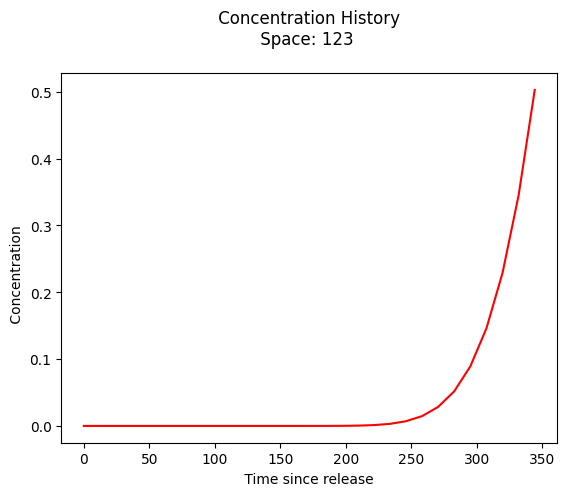

In [4]:
#
# forward define and initialize vectors for a profile plot
#
how_many_points = 29   
deltat = 12.3
t = [0.0 for i in range(how_many_points)]  # constructor notation
c = [0.0 for i in range(how_many_points)]  # constructor notation

t[0]=1e-5 #cannot have zero time, so use really small value first position in list
#
# build the profile predictions
#
for i in range(0,how_many_points,1):
    if i > 0:
        t[i]=t[i-1]+deltat
    c[i] = willsonmiller(c_injection,q_injection,l_thickness,d_x,d_y,decay,velocity,x_location,y_location,t[i])

#
# Import graphics routines for picture making
#
from matplotlib import pyplot as plt
#
# Build and Render the Plot
#
plt.plot(t,c, color='red', linestyle = 'solid')  # make the plot object
plt.title(" Concentration History \n Space: " + repr(x_location) + "  \n") # caption the plot object
plt.xlabel(" Time since release ") # label x-axis
plt.ylabel(" Concentration        ") # label y-axis
#plt.savefig("ogatabanksplot.png") # optional generates just a plot for embedding into a report
plt.show() # plot to stdio -- has to be last call as it kills prior objects
plt.close('all') # needed when plt.show call not invoked, optional here
#sys.exit() # used to elegant exit for CGI-BIN use


In [5]:
# make a plot
x_max = 200
y_max = 100
# build a grid
nrows = 50   
deltax = (x_max*4)/nrows
x = []
x.append(-x_max)
for i in range(nrows):
    if x[i] == 0.0:
        x[i] = 0.00001
    x.append(x[i]+deltax)

ncols = 50   
deltay = (y_max*2)/(ncols-1)
y = []
y.append(-y_max)
for i in range(1,ncols):
    if y[i-1] == 0.0:
        y[i-1] = 0.00001
    y.append(y[i-1]+deltay)
    
#y

#y = [i*deltay for i in range(how_many_points)] # constructor notation
#y[0]=0.001
ccc = [[0 for i in range(nrows)] for j in range(ncols)]

for jcol in range(ncols):
    for irow in range(nrows):
        ccc[irow][jcol] = willsonmiller(c_injection,q_injection,l_thickness,d_x,d_y,decay,velocity,x[irow],y[jcol],time)
        
#y

my_xyz = [] # empty list
count=0
for irow in range(nrows):
    for jcol in range(ncols):
        my_xyz.append([ x[irow],y[jcol],ccc[irow][jcol] ])
       # print(count)
        count=count+1
        
#print(len(my_xyz))

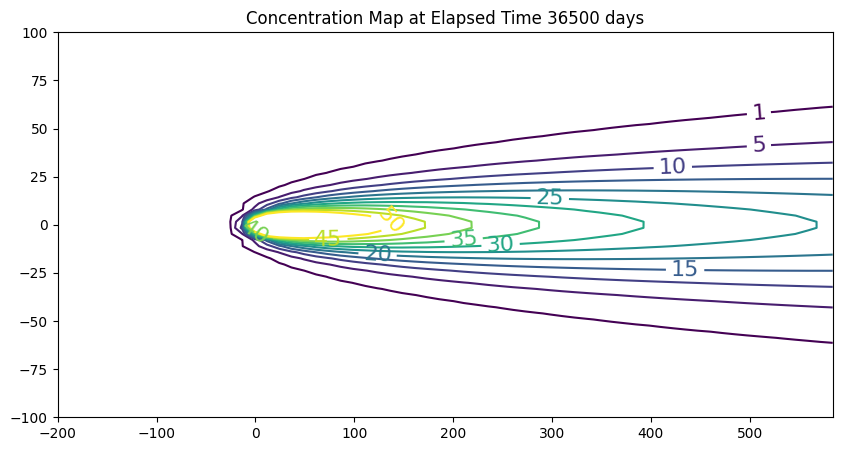

In [6]:
import pandas
my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
import numpy 
import matplotlib.pyplot
from scipy.interpolate import griddata
# extract lists from the dataframe
coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
#print(min(coord_x), max(coord_x)) # activate to examine the dataframe
#print(min(coord_y), max(coord_y))
coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
lon = numpy.linspace(min(coord_x), max(coord_x), 64)
lat = numpy.linspace(min(coord_y), max(coord_y), 64)
X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(10, 5)
CS = ax.contour(X, Y, Z, levels = [1,5,10,15,20,25,30,35,40,45,50])
ax.clabel(CS, inline=2, fontsize=16)
ax.set_title('Concentration Map at Elapsed Time '+ str(round(time,1))+' days');

2.0 1.0 140000.0 374.16573867739413 2333.3333333333335 187.08286933869707
2.0 1.0 133856.0 365.86336247293195 2230.9333333333334 182.93168123646598
2.0 1.0 128224.0 358.0837890773611 2137.0666666666666 179.04189453868054
2.0 1.0 123104.0 350.8617961534142 2051.733333333333 175.4308980767071
2.0 1.0 118496.0 344.23247958320263 1974.9333333333334 172.11623979160132
2.0 1.0 114400.0 338.23069050575526 1906.6666666666667 169.11534525287763
2.0 1.0 110816.0 332.8903723450109 1846.9333333333334 166.44518617250546
2.0 1.0 107744.0 328.2438118228583 1795.7333333333333 164.12190591142914
2.0 1.0 105184.0 324.3208288099918 1753.0666666666666 162.1604144049959
2.0 1.0 103136.0 321.1479409867048 1718.9333333333334 160.5739704933524
2.0 1.0 101600.0 318.74754901018457 1693.3333333333333 159.37377450509229
2.0 1.0 100576.0 317.13719428663677 1676.2666666666667 158.56859714331839
2.0 1.0 100064.0 316.3289427162807 1667.7333333333333 158.16447135814036
2.0 1.0 100064.0 316.3289427162807 1667.733333333

<ipython-input-57-b0408860a786>:68: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(X, Y, Z, levels = [1,5,10,15,20,25,30,35,40,45,50])


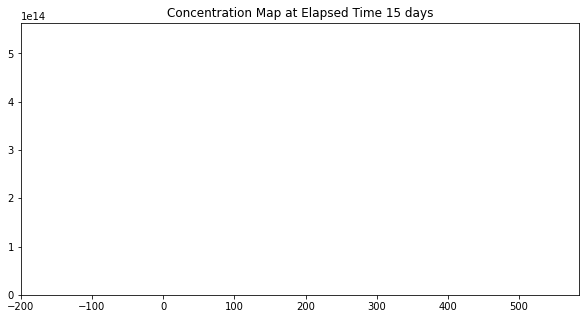